In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout,AveragePooling2D,Dense,Conv2D,MaxPooling2D,Activation,Concatenate,GlobalAveragePooling2D,Flatten
from tensorflow.keras import Input

def inception(x_in, x1_f,x3r_f,x3_f,x5r_f,x5_f,po):
    
    x1 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding = 'SAME')(x_in)
    x1 = Conv2D(filters= po,kernel_size=(1,1),padding="SAME")(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters=x5r_f,kernel_size=(1,1),padding="SAME")(x_in)
    x2 = Conv2D(filters=x5_f,kernel_size=(5,5),padding="SAME")(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(filters=x3r_f,kernel_size=(1,1),padding="SAME")(x_in)
    x3 = Conv2D(filters=x3_f,kernel_size=(3,3),padding="SAME")(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv2D(filters=x1_f,kernel_size=(1,1),padding="SAME")(x_in)
    x4 = Activation('relu')(x4)

    out = Concatenate()([x1,x2,x3,x4])
    return out


input_data = Input(shape=(224,224,3))
x = Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding="SAME")(input_data)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)
x = tf.keras.layers.LayerNormalization()(x)

x = Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding="SAME")(x)
x = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding="SAME")(x)

x = tf.keras.layers.LayerNormalization()(x)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)


x = inception(x,64,96,128,16,32,32)
x = inception(x,128,128,192,32,96,64)

x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)
x = inception(x,192,96,208,16,48,64)

ax1 = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)
ax1 = Conv2D(filters=128,kernel_size=(1,1),padding="SAME")(ax1)
ax1 = Flatten()(ax1)
ax1 = Dense(1024,activation="relu")(ax1)
ax1 = Dropout(0.7)(ax1)
ax1 = Dense(1000,activation="softmax")(ax1)

x = inception(x,160,112,224,24,64,64)
x = inception(x,128,128,256,24,64,64)

x = inception(x,112,114,288,32,64,64)

ax2 = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)
ax2 = Conv2D(filters=128,kernel_size=(1,1),padding="SAME")(ax2)
ax2 = Flatten()(ax2)
ax2 = Dense(1024,activation="relu")(ax2)
ax2 = Dropout(0.7)(ax2)
ax2 = Dense(1000,activation="softmax")(ax2)

x = inception(x,256,160,320,32,128,128)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)

x = inception(x,256,160,320,32,128,128)
x = inception(x,384,192,384,48,128,128)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

outputs = Dense(1000,activation="softmax")(x)
googlenet = tf.keras.models.Model(input_data,[outputs,ax1,ax2],name = 'googlenet')
googlenet.summary()

# PyTorch로 GoogLeNet 구현하기

데이터셋 불러오기

In [ ]:
from google.colab import drive 
drive.mount('googlenet')

Mounted at googlenet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


STL10 dataset 불러오기

In [ ]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [ ]:
# specify the data pasth
path2data = '/content/googlenet/MyDrive/data/'

# if not exist the path, make the directory
if not os.path.exists(path2data):
  os.mkdir(path2data)

#load dataset
train_ds = datasets.STL10(path2data, split='train',
                          download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, 
                        transform=transforms.ToTensor())
print(len(train_ds))
print(len(val_ds))

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/googlenet/MyDrive/data/stl10_binary.tar.gz to /content/googlenet/MyDrive/data/
Files already downloaded and verified
5000
8000


In [ ]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.detach().cpu().numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.detach().cpu().numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.detach().cpu().numpy(), axis=(1,2)) for x, _ in val_ds]
val_stdRGB = [np.std(x.detach().cpu().numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)
     

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


transformation 객체를 생성

In [ ]:
from tensorflow.python import train
# define the image transformation
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB], 
                                             [train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB], 
                                             [train_stdR, train_stdG, train_stdB]),
])

# apply transformation
train_ds.transform = train_transformation
val_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

샘플 이미지를 확인

image indices:  [2732 2607 1653 3264]


torch.Size([3, 228, 906])


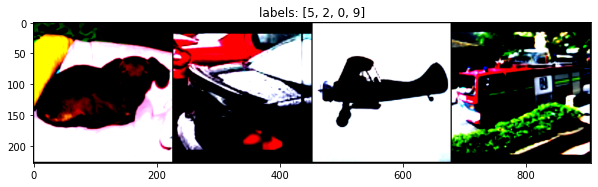

In [ ]:
# display sample images
def show(img, y=None, color=True): 
  npimg = img.detach().cpu().numpy()
  npimg_tr = np.transpose(npimg, (1,2,0))
  plt.imshow(npimg_tr)

  if y is not None:
    plt.title('labels: ' + str(y))

np.random.seed(0)
torch.manual_seed(0)

grid_size = 4
rnd_inds = np.random.randint(0,len(train_ds), grid_size)
print("image indices: ", rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

# 2. 모델 구축
https://www.youtube.com/watch?v=uQc4Fs7yx5I&t=39s


In [ ]:
class GoogLeNet(nn.Module):
  def __init__(self, aux_logits=True, num_classes=10, init_weights=True):
    super(GoogLeNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    # conv_block takes in_channels, out_channels, kernel_size, tride, padding
    # Inception block takes out 1*1, red_3*3, out_3*3, red_5*5, out_1*1poll

    self. conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
    self.maxpool1 = nn.MaxPool2d(3,2,1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(3,2,1)
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(3,2,1)
    self.inception4a = Inception_block(192, 64, 96, 128, 16, 32, 32)

    # auxiliary classifier (보조 분류기)

    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

    # auxiliary classifier (보조 분류기)

    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(3,2,1)
    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)
    self.avgpool = nn.AvgPool2d(7,1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

    if self.aux_logits:
      self.aux1 = InceptionAux(512, numclasses)
      self.aux2 = InceptionAux(528, numclasses)
    else:
      self.aux1 = self.aux2 = None
    
    # weight initalization
    if init_weights:
      self._initialize_weights()

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)
    x = self.inception4a(x)

    if self.aux_logits and self.training:
      aux1 = self.aux1(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    if self.aux_logits and self.training:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)

    x = x.view(x.shape[0], -1)
    #추가
    x = x.reshape(x.shape[0], -1)

    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training:
      return x, aux1, aux2
    else:
      return x

  # define weight initialization function
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.contant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)



class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.conv_layer(x)


class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red3x3, 
               out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()

    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
        conv_block(in_channels, red_3x3, kernel_size=1),
        conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
    )

    self.branch3 = nn.Sequential(
        conv_block(in_channels, red_5x5, kernel_size=1),
        conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        conv_block(in_channels, out_1x1pool, kernel_size=1)
    )

  def forward(self, x):
    # 0차원은 batch이므로 1차원인 filter 수를 기준으로 각 branch의 출력값ㅇ르 묶어줌
    x = torch.cat([self.branch1(x), self.branch2(x), 
                   self.branch3(x), self.branch4(x)], 1)
    return x







# auxiliary classifier 의 loss는 0.3이 곱해지고, 최종 loss에 추가한다.
# 정규화 효과가 있다.
class InceptionAux(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(InceptionAux, self).__init__()

    self.conv = nn.Sequential(
        nn.AvgPool2d(kernel_size=5, stride=3),
        conv_block(in_channels, 128, kernel_size=1),
    )

    self.fc = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(1024, num_classes),
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x




if __name__ == '__main__':
  x = torch.randn(3, 3, 224, 224)
  model = GoogLeNet()
  print(model(x).shape)

NameError: ignored

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self,aux_logits=True, num_classes=10, init_weights=True):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # conv_block takes in_channels, out_channels, kernel_size, stride, padding
        # Inception block takes out1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, 2, 1)
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, 2, 1)
        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)

        # auxiliary classifier

        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

        # auxiliary classifier

        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, 2, 1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(7, 1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)

        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = x.view(x.shape[0], -1)

        x = self.dropout(x)
        x = self.fc1(x)

        if self.aux_logits and self.training:
            return x, aux1, aux2
        else:
            return x 

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv_layer(x)


class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        # 0차원은 batch이므로 1차원인 filter 수를 기준으로 각 branch의 출력값을 묶어줍니다. 
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
        return x

# auxiliary classifier의 loss는 0.3이 곱해지고, 최종 loss에 추가합니다. 정규화 효과가 있습니다. 
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            conv_block(in_channels, 128, kernel_size=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


# if __name__ == '__main__':
#   x = torch.randn(3, 3, 224, 224)
#   model = GoogLeNet()
#   print(model(x).shape)

모델 확인

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GoogLeNet(aux_logits=True, num_classes=10, init_weights=True).to(device)
print(model)


In [ ]:
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output)

model summary 출력

In [ ]:
summary(model, input_size=(3, 224, 224), device=device.type)

# 3. 학습하기

In [ ]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']


def metric_batch(output, target):
  pred = output.argmax(dim=1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects


def loss_batch(output, target):
  if np.shape(outputs)[0] == 3:
    output, aux1, aux2 = outputs

    output_loss = loss_func(output, target)
    aux1_loss = loss_func(aux1, target)
    aux2_loss = loss_func(aux2, target)

    loss = output_loss + 0.3*(aux1_loss + aux2_loss)
    metric_b = metric_batch(output, target)

  else:
    loss = loss_func(outputs, target)
    metric_b = metric_batch(outputs, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric_b 


def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break

  loss = running_loss / len_data 
  metric = running_metric / len_data 

  return loss, metric


def train_val(model, params):
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  tarin_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  loss_history = {'train': [], 'val': []}
  metric_history = {'train': [], 'val': []}

  best_model_wts = copy.deepcopy(model.state_dict())

  best_loss = float('inf')

  start_time = time.time()
  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

    model.train()
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

      if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

        torch.save(model.state_dict(), path2weights)
        print('Copied best model weights!')

      loss_history['val'].append(val_loss)
      metric_history['val'].append(val_metric)

      lr_scheduler.step()

      print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
      print('-'*10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

위 코드에서 중요한 점은 aux1 loss 와 aux2 loss 를 total loss에 더해줘야 한다.

In [ ]:
def loss_batch(loss_func, outputs, target, opt=None):
    if np.shape(outputs)[0] == 3:
        output, aux1, aux2 = outputs

        output_loss = loss_func(output, target)
        aux1_loss = loss_func(aux1, target)
        aux2_loss = loss_func(aux2, target)

        loss = output_loss + 0.3*(aux1_loss + aux2_loss)
        metric_b = metric_batch(output,target)

    else:
        loss = loss_func(outputs, target)
        metric_b = metric_batch(outputs, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b

하이퍼파라미터 설정

In [ ]:
# definc the training parameters
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()